# Bag of char ngrams erstellen

* J.Busse, www.jbusse.de, 2023-05-30
* Version für n-Gramme, basierend auf {doc}`bag-of-words-erstellen`

Lizenz: public domain / [CC 0](https://creativecommons.org/publicdomain/zero/1.0/deed.de) 

Idee:

> one might alternatively consider a collection of character n-grams, a representation resilient against misspellings and derivations. <https://scikit-learn.org/stable/modules/feature_extraction.html#limitations-of-the-bag-of-words-representation>

Dateien:
* {download}`regex_XX.zip`
* auspacken; das Verzeichnis `regex_XX/` sollte idealerweise als Geschwister-Verzeichnis des aktuellen Arbeitsverzeichnis `md/` angelegt werden -- oder ggf. Variable `path_to_md` anpassen.

### Global Parameters

In [1]:
import numpy as np
import pandas as pd
import random
random.seed(42)

In [2]:
# show intermediary results
# 0 none, 1 informative, 2 didactical, 3 debug
verbosity = 2

def verbose(level,item):
    if level <= verbosity:
        display(item)

In [3]:
fehler = 0.3

## Tippfehler

Idee: Wir bauen in unsere Texte programmatisch eine hohe Anzahl von Tippfehlern ein. Ein konventioneller BOW-Ansatz auf Wort-Ebene sollte hier keine große Ähnlichkeit mehr entdecken.

In [4]:
tastatur = (
"""qw we er rt tz ty zu ui io op pü""" # obere Reihe
"""as sd df fg gh hj jk kl lö öä""" # mittlere Reihe
"""yx yz xc cv vb bn nm"""  # untere Reihe
"""12 23 34 45 56 67 78 89 90"""
)

# alle Zeichen, für die wir Fehler kennen
tastatur_set = { c for word in tastatur.split() for c in word  }
print(tastatur_set)

{'ü', 'c', 'u', 'd', '6', '8', 'o', 'ö', 'q', 'f', 'l', 'v', '3', 'ä', 'm', 'w', '5', 'x', 'a', 's', 'z', 'e', '1', 't', 'g', '2', '7', '4', 'n', 'i', '9', 'j', 'y', 'p', 'k', '0', 'b', 'r', 'h'}


In [5]:
nachbarn_set = { c: set() for c in tastatur_set}
for word in tastatur.split():
    for c in word:
        nachbarn_set[c].update(word)
#print(nachbarn_set)

In [6]:
nachbarn_dict = { k: list(v) for k,v in nachbarn_set.items() }
print(nachbarn_dict)

{'ü': ['s', 'ü', 'p', 'a'], 'c': ['v', 'c', 'x'], 'u': ['i', 'u', 'z'], 'd': ['s', 'd', 'f'], '6': ['5', '6', '7'], '8': ['9', '7', '8'], 'o': ['o', 'i', 'p'], 'ö': ['y', 'x', 'ö', 'l', 'ä'], 'q': ['w', 'q'], 'f': ['d', 'f', 'g'], 'l': ['k', 'ö', 'l'], 'v': ['c', 'b', 'v'], '3': ['4', '2', '3'], 'ä': ['y', 'x', 'ä', 'ö'], 'm': ['m', 'n', '2', '1'], 'w': ['w', 'e', 'q'], '5': ['4', '5', '6'], 'x': ['c', 'y', 'x', 'ö', 'ä'], 'a': ['s', 'ü', 'p', 'a'], 's': ['ü', 'd', 'p', 's', 'a'], 'z': ['y', 'u', 'z', 't'], 'e': ['w', 'e', 'r'], '1': ['m', 'n', '2', '1'], 't': ['z', 'y', 'r', 't'], 'g': ['h', 'f', 'g'], '2': ['m', '3', '2', 'n', '1'], '7': ['6', '7', '8'], '4': ['4', '5', '3'], 'n': ['m', 'b', '2', 'n', '1'], 'i': ['o', 'i', 'u'], '9': ['0', '9', '8'], 'j': ['j', 'k', 'h'], 'y': ['t', 'y', 'x', 'ö', 'z', 'ä'], 'p': ['ü', 'p', 'o', 's', 'a'], 'k': ['j', 'k', 'l'], '0': ['0', '9'], 'b': ['n', 'b', 'v'], 'r': ['e', 'r', 't'], 'h': ['j', 'h', 'g']}


In [7]:
import random
def dreher(zeichen, fehler):
   if zeichen not in tastatur_set: return zeichen
   t = random.random()
   if t < fehler: ret = random.choice(nachbarn_dict[zeichen])
   else: ret = zeichen # nix falsch gemacht
   return ret

In [8]:
for c in "Hallo Hugo":
    print(dreher(c, 0.3))

H
a
ö
k
o
 
H
u
g
i


Read Files 
----

In [9]:
# path to files, incl. glob mask
#path_to_md = "md/*.md"
path_to_md = "../regex_XX/*.md"

In [10]:
# https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
import glob
files = glob.glob(path_to_md)
verbose(1,f"{len(files)} Dateien gefunden")
files

'15 Dateien gefunden'

['../regex_XX/regex_8.md',
 '../regex_XX/regex_6.md',
 '../regex_XX/regex_5.md',
 '../regex_XX/regex_12.md',
 '../regex_XX/regex_wiki_2.md',
 '../regex_XX/regex_9.md',
 '../regex_XX/regex_2.md',
 '../regex_XX/regex_15.md',
 '../regex_XX/regex_4.md',
 '../regex_XX/regex_wiki_1.md',
 '../regex_XX/regex_14.md',
 '../regex_XX/regex_10.md',
 '../regex_XX/regex_7.md',
 '../regex_XX/regex_1.md',
 '../regex_XX/regex_13.md']

Wir lesen die Daten in das Dictionary `corpus_dict` ein:

In [11]:
corpus_dict_of_strings = {}

for file in files:
    with open(file, 'r') as f:
        corpus_dict_of_strings[file] = f.read()
verbose(2,corpus_dict_of_strings)

{'../regex_XX/regex_8.md': 'Reguläre Ausdrücke finden in der Informatik sehr häufige Anwendung.\nSie sind vor allem bei der Suche von großer Bedeutung.\nBeispielsweise kann durch Angeben des Suchkriteriums ".*" jede beliebige Zeichenfolge gefunden werden.\nDabei steht der Punkt für EIN beliebiges Zeichen und der Stern dahinter für eine beliebige Anzahl dieses vorangegangenen Zeichens.',
 '../regex_XX/regex_6.md': 'Kann beim Programmieren für diverse Problemlösungen verwendet werden um in Strings etwas zu \nsuchen oder darin etwas zu prüfen bzw. zu bearbeiten. \nReguläre Ausdrücke werden auch als RegEx abgekürzt.',
 '../regex_XX/regex_5.md': '\nRegex wird benutzt um Texte nach bestimmten Mustern zu durchsuchen.\nDafür wird eine Zeichenkette aus verschiedenen Symbolen verwendet welche das zu suchende Muster beschreiben.\nReguläre Ausdrücke gehören zu den formalen Sprachen.\nDie Symbole sind teil der Sprachgrammatik.\nAußerdem kann man aus Regex einen endlichen Automat bilden und umgekehr

In [12]:
corpus2 = {}
for v,k in corpus_dict_of_strings.items():
    neu = v + "_dreher"
    corpus2[neu] = "".join([dreher(c, fehler) for c in k ])
corpus_dict_of_strings.update(corpus2)
corpus_dict_of_strings

{'../regex_XX/regex_8.md': 'Reguläre Ausdrücke finden in der Informatik sehr häufige Anwendung.\nSie sind vor allem bei der Suche von großer Bedeutung.\nBeispielsweise kann durch Angeben des Suchkriteriums ".*" jede beliebige Zeichenfolge gefunden werden.\nDabei steht der Punkt für EIN beliebiges Zeichen und der Stern dahinter für eine beliebige Anzahl dieses vorangegangenen Zeichens.',
 '../regex_XX/regex_6.md': 'Kann beim Programmieren für diverse Problemlösungen verwendet werden um in Strings etwas zu \nsuchen oder darin etwas zu prüfen bzw. zu bearbeiten. \nReguläre Ausdrücke werden auch als RegEx abgekürzt.',
 '../regex_XX/regex_5.md': '\nRegex wird benutzt um Texte nach bestimmten Mustern zu durchsuchen.\nDafür wird eine Zeichenkette aus verschiedenen Symbolen verwendet welche das zu suchende Muster beschreiben.\nReguläre Ausdrücke gehören zu den formalen Sprachen.\nDie Symbole sind teil der Sprachgrammatik.\nAußerdem kann man aus Regex einen endlichen Automat bilden und umgekehr

In [13]:
def clean_string(string):
    """Liefert string "gesäubert" wieder als String zurück: 
    Interpunktionen, Sonderzeichen etc. 
    werden in Leerzeichen umgewandelt."""
    alnum = lambda x: x if x.isalnum() else " "
    return "".join(alnum(c) for c in string )

In [14]:
corpus_list_of_lists = [ clean_string(text).split() 
                        for text in corpus_dict_of_strings.values() ]
verbose(2, corpus_list_of_lists[-1])

['Mithilfe',
 'von',
 'Regrx',
 'kan2',
 'man',
 'Twäre',
 'nach',
 'bestimmte1',
 'Eigenschaften',
 'überürüfrn',
 'und',
 'Foltern',
 'Bwispiwlsqeusr',
 'kann',
 'msn',
 'somut',
 'Trlefo1nummern',
 'aus',
 'eumw1',
 'Webdeite',
 'hetausfindr1',
 'ojne',
 'frpß',
 'suche1',
 'tu',
 'müssen']

## n-Gramme von Zeichen

Idee: Wir repräsentieren einzene Wörter nicht durch sich selbst, sondern durch n-Gramme auf Zeichen-Ebene, üblicherweise mit n = 3.

In [15]:
corpus_as_words = [ " ".join(word_list) for word_list in corpus_list_of_lists ]
verbose(2, corpus_as_words[-1])

'Mithilfe von Regrx kan2 man Twäre nach bestimmte1 Eigenschaften überürüfrn und Foltern Bwispiwlsqeusr kann msn somut Trlefo1nummern aus eumw1 Webdeite hetausfindr1 ojne frpß suche1 tu müssen'

In [16]:
def n_char_substrings(string, n=3, low = True):
    if len(string) < n:
        return []
    elif low:
        return [string[i:i+n].lower() for i in range(0, len(string)-n+1)]
    else:
        return [string[i:i+n]for i in range(0, len(string)-n+1)]

In [17]:
corpus_list_of_ngrams = [ ]
for text in corpus_list_of_lists:
    ngram_list = []
    for word in text:
        ngram_list.extend(n_char_substrings(word))
    corpus_list_of_ngrams.append(ngram_list)
verbose(2, corpus_list_of_ngrams[1][0:20])

['kan',
 'ann',
 'bei',
 'eim',
 'pro',
 'rog',
 'ogr',
 'gra',
 'ram',
 'amm',
 'mmi',
 'mie',
 'ier',
 'ere',
 'ren',
 'für',
 'div',
 'ive',
 'ver',
 'ers']

In [18]:
corpus_as_ngrams = [ " ".join(ngram_list) for ngram_list in corpus_list_of_ngrams ]
verbose(2, corpus_as_ngrams[0])

'reg egu gul ulä lär äre aus usd sdr drü rüc ück cke fin ind nde den der inf nfo for orm rma mat ati tik seh ehr häu äuf ufi fig ige anw nwe wen end ndu dun ung sie sin ind vor all lle lem bei der suc uch che von gro roß oße ßer bed ede deu eut utu tun ung bei eis isp spi pie iel els lsw swe wei eis ise kan ann dur urc rch ang nge geb ebe ben des suc uch chk hkr kri rit ite ter eri riu ium ums jed ede bel eli lie ieb ebi big ige zei eic ich che hen enf nfo fol olg lge gef efu fun und nde den wer erd rde den dab abe bei ste teh eht der pun unk nkt für ein bel eli lie ieb ebi big ige ges zei eic ich che hen und der ste ter ern dah ahi hin int nte ter für ein ine bel eli lie ieb ebi big ige anz nza zah ahl die ies ese ses vor ora ran ang nge geg ega gan ang nge gen ene nen zei eic ich che hen ens'

## Bibliothek

minmales Beispiel aus https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [19]:
import sklearn
#sklearn.show_versions()
from sklearn.feature_extraction.text import TfidfVectorizer

In [20]:
# tv ... *t*fidf *v*ectorizer itself
vectorizer_tv = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,3)
    )
X_tv = vectorizer_tv.fit_transform(corpus_as_words)

In [21]:
vectorizer_tv.get_feature_names_out()

array([' 0 ', ' 1a', ' 1x', ..., 'üxh', 'üxj', 'üxk'], dtype=object)

## TfidfVectorizer

Doku:
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [22]:

vectorizer_words = TfidfVectorizer()
X_words = vectorizer_words.fit_transform(corpus_as_words)
verbose(2, vectorizer_words.get_feature_names_out()[0:100])

array(['1an', '1xföich', '1yglich', '2it', 'a2', 'a2zshl', 'aber',
       'aberprüfen', 'abgeglichen', 'abgeglivhen', 'abgekürzt',
       'abkürzung', 'ablüezung', 'aimplr', 'aind', 'aisfruck', 'aks',
       'alkem', 'alle', 'allem', 'als', 'alöe', 'alöwm', 'alü', 'am',
       'an', 'and', 'aneendung', 'angeben', 'angrben', 'anwendung',
       'anwendungsfakl', 'anwendungsfall', 'anwenfung', 'anywhere',
       'anywjete', 'anzahl', 'anzshl', 'anzühl', 'auch', 'auddeick',
       'auddravke', 'auf', 'aupdepcke', 'aupdrucjs', 'aus', 'ausaxhnitte',
       'ausdeüvke', 'ausdracke', 'ausdricks', 'ausdrpcje', 'ausdrpcke',
       'ausdruck', 'ausdrucks', 'ausdruvjd', 'ausdrzcks', 'ausdrücje',
       'ausdrücke', 'ausdrücken', 'ausdrückr', 'ausdtpclw1', 'ausdtuck',
       'ausfrackrb', 'ausfrzck', 'ausfrücken', 'ausschnitte', 'aussrick',
       'automarem', 'automat', 'automaten', 'automüt', 'auxh', 'außerdem',
       'außerdwm', 'auüdrücke', 'avfrkürzz', 'aynyaktiscgrr', 'azpdrüxke',
       'a

In [23]:
vectorizer_ngrams = TfidfVectorizer()
X_ngrams = vectorizer_ngrams.fit_transform(corpus_as_ngrams)
verbose(2, vectorizer_ngrams.get_feature_names_out()[0:100])

array(['1al', '1an', '1de', '1em', '1en', '1ma', '1nu', '1oc', '1ti',
       '1ue', '1xf', '1yg', '2bo', '2e1', '2er', '2es', '2it', '2kt',
       '2pu', '2si', '2st', '2zs', 'a1m', 'a2n', 'a2z', 'abe', 'abg',
       'abk', 'abl', 'abn', 'ach', 'acj', 'ack', 'act', 'aea', 'aed',
       'aet', 'aez', 'afa', 'afd', 'aft', 'afü', 'agi', 'ags', 'ahi',
       'ahl', 'aim', 'ain', 'aio', 'ais', 'akl', 'aks', 'akt', 'aky',
       'ale', 'alk', 'all', 'alr', 'als', 'alö', 'alü', 'am1', 'amm',
       'amn', 'an1', 'an2', 'anb', 'and', 'ane', 'ang', 'ann', 'anw',
       'any', 'anz', 'ape', 'api', 'apr', 'ara', 'arb', 'ard', 'are',
       'ari', 'arp', 'ars', 'ase', 'ass', 'ast', 'asw', 'atc', 'ate',
       'ati', 'ato', 'atp', 'att', 'atv', 'atx', 'aub', 'auc', 'aud',
       'auf'], dtype=object)

In [24]:
#matrix_words = X_words
#matrix_ngrams = X_ngrams

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [26]:
similarity_words = cosine_similarity(X_words)
similarity_df_words = pd.DataFrame(similarity_words)
similarity_df_words.columns = corpus_dict_of_strings.keys() 
similarity_df_words.index = corpus_dict_of_strings.keys()

similarity_ngrams = cosine_similarity(X_ngrams)
similarity_df_ngrams = pd.DataFrame(similarity_ngrams)
similarity_df_ngrams.columns = corpus_dict_of_strings.keys() 
similarity_df_ngrams.index = corpus_dict_of_strings.keys()

similarity_tv = cosine_similarity(X_tv)
similarity_df_tv = pd.DataFrame(similarity_tv)
similarity_df_tv.columns = corpus_dict_of_strings.keys() 
similarity_df_tv.index = corpus_dict_of_strings.keys()

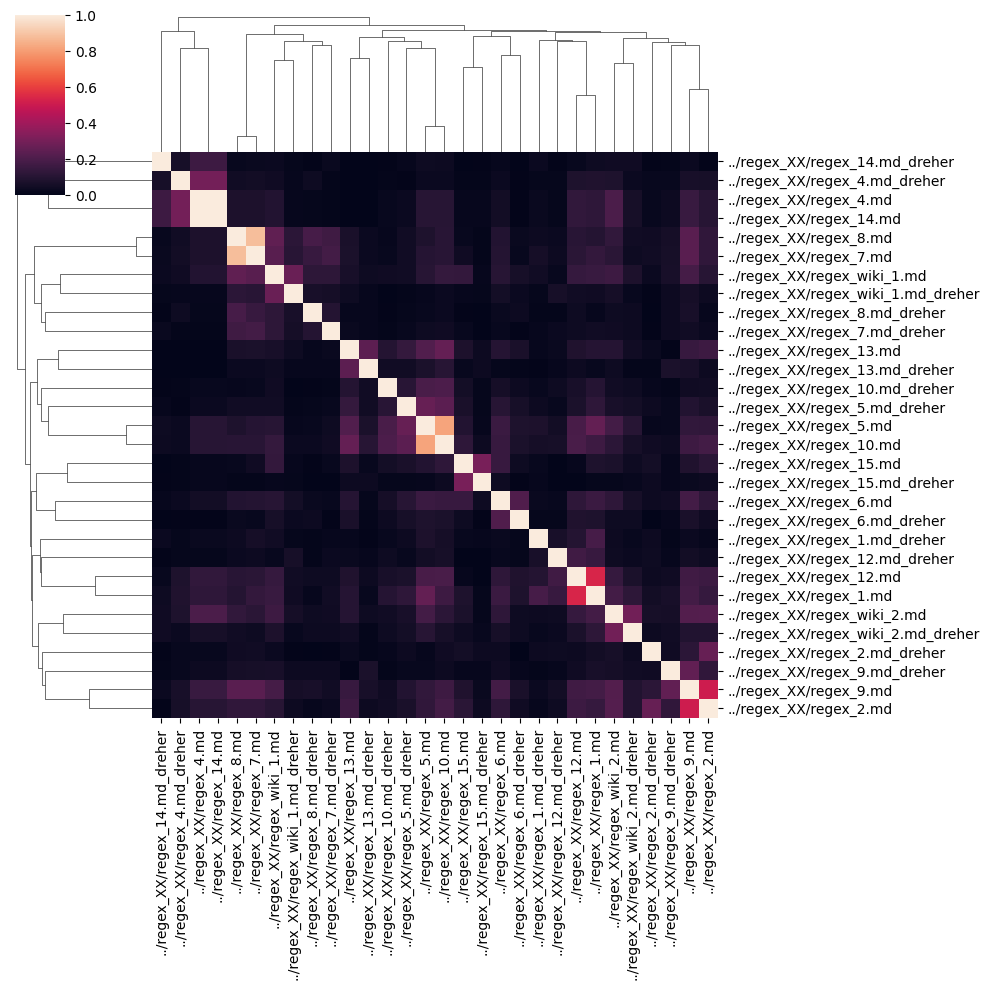

In [27]:
ax_words = sns.clustermap(similarity_df_words)
# ax.savefig("clustermap_words.png")

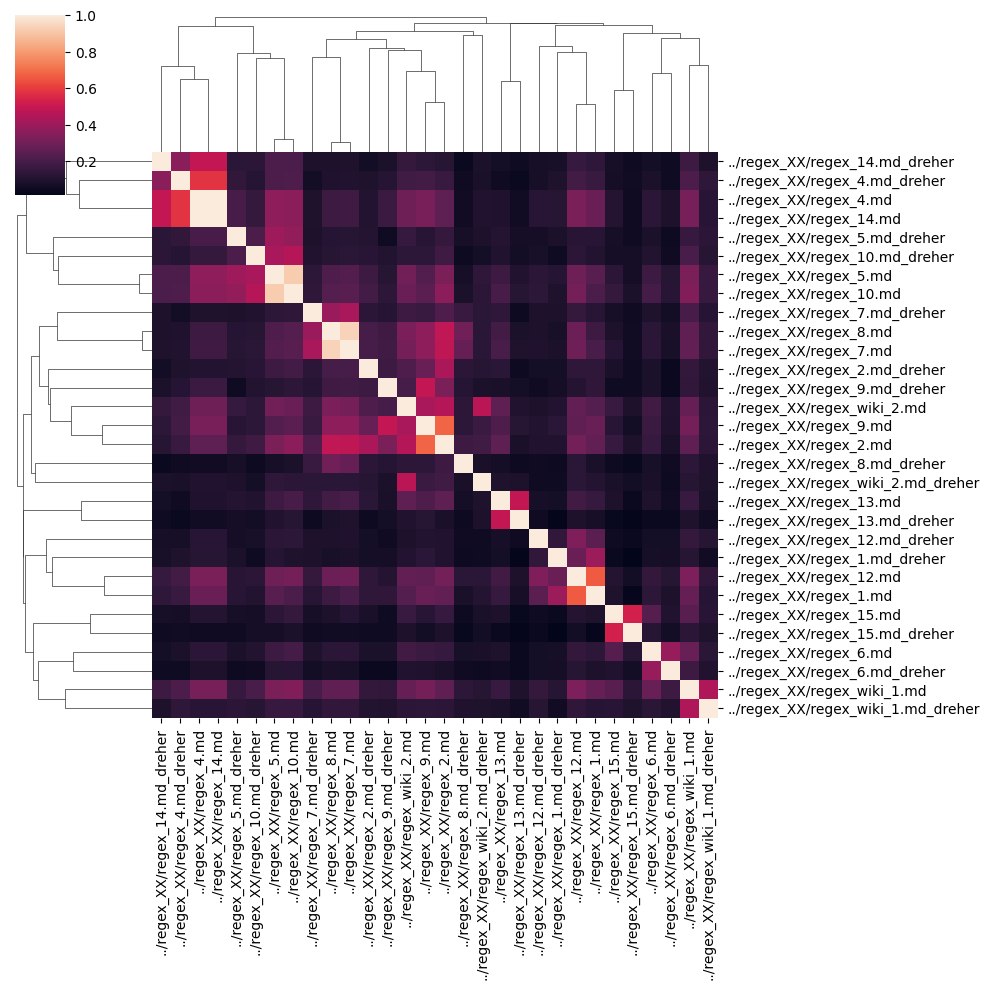

In [28]:
ax_ngrams = sns.clustermap(similarity_df_ngrams)

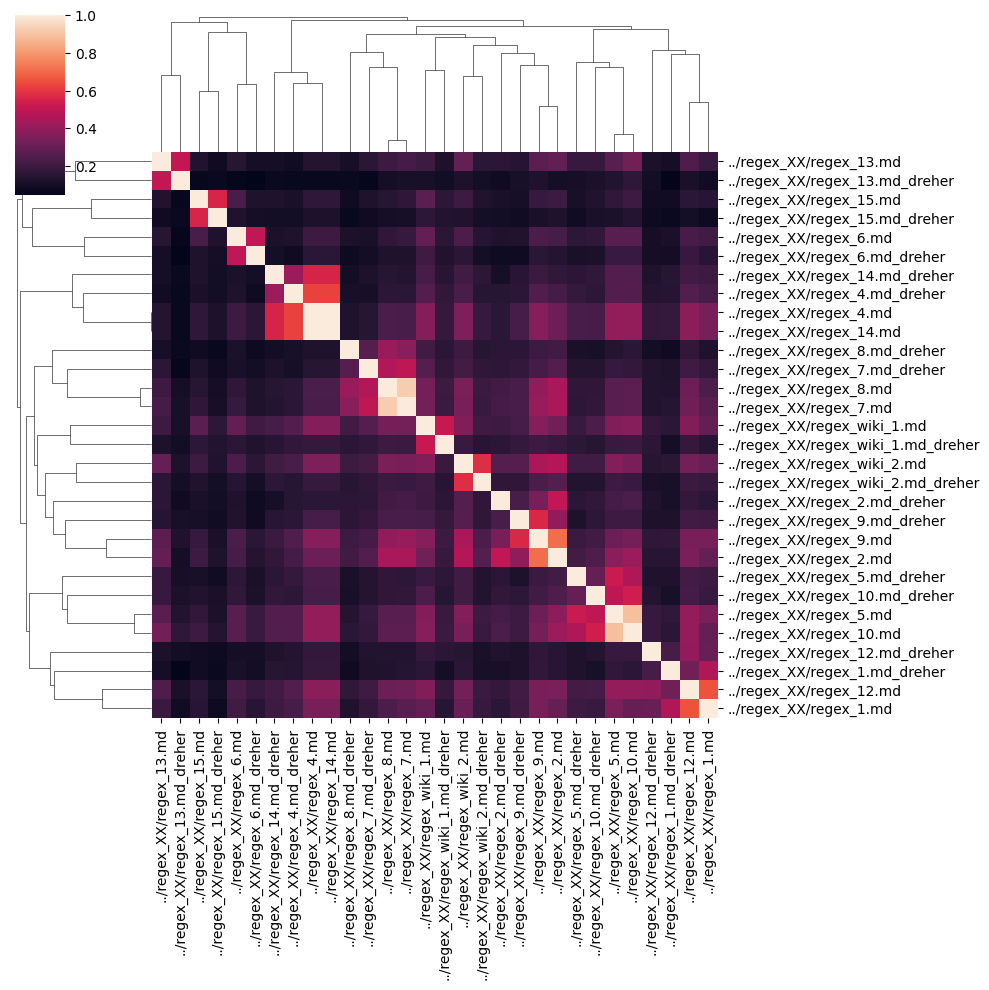

In [29]:
ax_tv = sns.clustermap(similarity_df_tv)